# Inner Visualizer Process

---

## 1. Set API Keys

In [1]:
import os

# Load API Keys
from config.secret_keys import OPENAI_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## 2. Import Modules

In [2]:
# directory setting
from pathlib import Path

# Define State
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# Define Tools
import pandas as pd
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# Define Agent
from langgraph.prebuilt import create_react_agent
from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate

# Define Node
from langgraph.prebuilt import ToolNode

# Build Graph
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage

## 3. Directory Setting

In [3]:
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data' # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / 'charts' # 차트 저장용 디엑토리

## 4. Build Application

### 4-1. Define State

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

### 4-2. Define Tools

In [5]:
# python code interpreter
repl = PythonREPL()

@tool
def python_repl(
    code : Annotated[str, "The Python code to execute to generate your chart."]
):
    """
    Use this to execute python code.

    If you want to see the output of a value, you should print it out with 'print(...)'. chart labels should be written in English.

    This is visible to the user.

    Use data for make the chart in './data/stock_data.csv' file.

    Please make the chart and save in './charts' folder.
    """

    try : 
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error : {repr(e)}"
    
    result_str = f"Successfully executed: \n```python\n{code}\n```Stdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, repond with FINAL ANSWER."
    )

tools = [python_repl]

### 4-3. Define Agent

In [6]:
llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tools)

In [13]:
today = datetime.today().date().strftime('%Y-%m-%d')

system_prompt = f"""
    Today is {today}.

    You are an exceptional data visualization expert. You must analyze the data, create, and save charts while adhering to the following mission:

    Your mission is:
    1. To uncover hidden insights in the given data and visualize them.
    2. To identify trends in the given data and visualize them.
    3. Use Data for visualize in './data/stock_data.csv' file.
    
    Always clearly explain your reasoning and support your conclusions with specific evidence.
    Be thorough in your analysis, but do not forget to maintain objectivity.
"""
visualize_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "user qustion : {question}")
    ]
)

visualize_specialist = visualize_prompt | llm_with_tools

### 4-4. Define Node

In [15]:
def inner_visualizer_node(state : dict):
    messages = state["messages"]

    result = visualize_specialist.invoke({"question" : messages[-1]})

    return {'message' : [result]}

tool_node = ToolNode(tools)

### 4-5. Define Conditional Edge Function

In [9]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

### 4-3. Build Graph

In [16]:
workflow = StateGraph(State)

workflow.add_node("inner_visualizer", inner_visualizer_node)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "inner_visualizer")

workflow.add_conditional_edges(
    "inner_visualizer",
    should_continue,
    {
        "continue" : "tool",
        "end" : END
    }
)
workflow.add_edge("tool", "inner_visualizer")

app = workflow.compile()

### 4-4. Visualize Graph

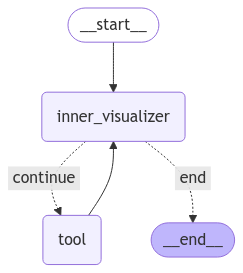

In [17]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
initial_input = {'messages' : [HumanMessage(content="주어진 데이터에 대해 시각화 해줘줘")]}

for chunk in app.stream(initial_input, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")

AttributeError: 'HumanMessage' object has no attribute 'tool_calls'